In [1]:
from migdalcalc import migdalcalc
from migdalcalc.migdal import kinematics as kin
from migdalcalc.migdal import ionization as ion
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = False

In [2]:
#Change these Variables here
En = 180e3 #Incident nuetron energy in eV
Angle = 15 #Lab Frame Scattering angle in deg

In [3]:
#Define various useful constants and quantities

A = 40
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second
days_to_seconds = 60*60*24 #days to seconds
phi_int = 2*np.pi #integral over 2pi in the azimuthal angle

R = 5 #cm
L = 1 #cm

V = (np.pi*R**2)*L
density = 1.395 #g / cm^3

mass = 1000 #grams

rate_prefactor = N_per_g*mass*barns_to_cm2*flux*days_to_seconds*phi_int
#TODO: conversion from cos theta to deg

In [4]:
#Cross Section of Elastic Scattering
Ar_migdal = migdalcalc.migdalcalc(target="Ar-40")

print("Argon Elastic Cross Section (barns): " + str(Ar_migdal.nuc.SIG(En)))

#Compute the Migdal Cross section
c_range = np.linspace(-1, 1)

mig_dE_spectrum = Ar_migdal.d2R_dc_dDeltaE(En)

mig_dE_arr = []

for c in c_range:
    dE_max = kin.DeltaE_Max(A, En, c)
    mig_dE = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE_max, limit=200, epsrel=1e-3)[0]
    
    mig_dE_arr.append(mig_dE)
    
elastic_xsec = Ar_migdal.nuc.SIG(En)
mig_total_xsec = integrate.trapz(mig_dE_arr, c_range)
mig_rate = np.floor(mig_total_xsec*rate_prefactor)

print("Argon Migdal Cross Section (barns): " + str(mig_total_xsec))

print()

print("Ratio migdal/elastic: " + str(mig_total_xsec/elastic_xsec))

print("Migdal Rate: " + "{r:e} evts/kg/day".format(r=mig_rate))

Argon Elastic Cross Section (barns): 4.71758
Argon Migdal Cross Section (barns): 0.02794221508259625

Ratio migdal/elastic: 0.0059229976137333655
Migdal Rate: 2.282921e+07 evts/kg/day


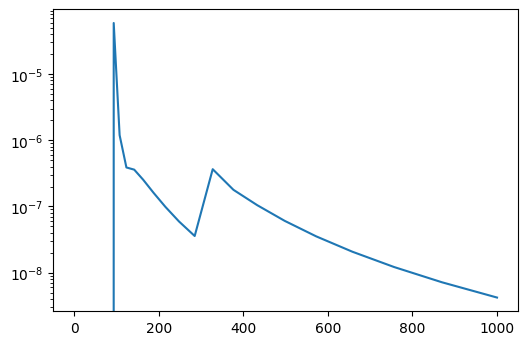

[ 58.5  78.   97.5 117.  136.5 156.  175.5 195.  214.5 234.  253.5 273.
 292.5 312.  331.5 351.  370.5 390.  409.5 429.  448.5]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
58.5 78.0 0.0
719.1417272463915
447212.08986454067
Elastic Recoil Energy: 306.4096985304249 eV


In [12]:
Ar_quench = lambda E: 0.25

c = np.cos(np.pi*Angle/180)

migdal_ionization_spectrum = Ar_migdal.dR_dEion(c, En, Ar_quench)

Eion_arr = np.geomspace(1e-3, 1000, 100)


plt.plot(Eion_arr, migdal_ionization_spectrum(Eion_arr))
plt.yscale('log')
plt.show()

#binned cross section in barns/deg (azimuth)/cos theta
binned_migdal_spectrum = ion.noblegas_electron_spectrum_binned(migdal_ionization_spectrum, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=False)

elastic_angular_spectrum = Ar_migdal.nuc.dSig_dOmega(En)
elastic_xsec = elastic_angular_spectrum(c)
migdal_xsec = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, 50000,limit=100, epsrel=1e-3)[0]
print(elastic_xsec/migdal_xsec)
binned_elastic_spectrum = ion.noblegas_electron_spectrum_binned_elastic(elastic_xsec, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=False )


print(np.sum(binned_migdal_spectrum[1])*rate_prefactor)

print("Elastic Recoil Energy: " + str(kin.E_Recoil(0, c, A, En)) + " eV")

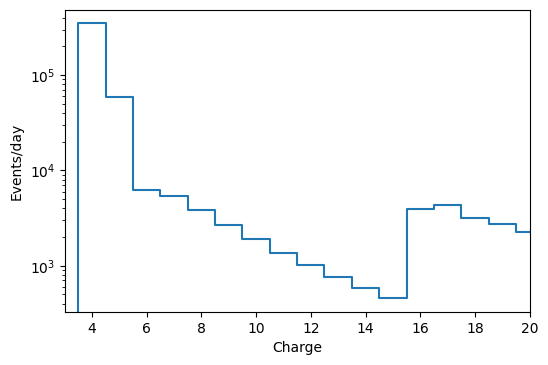

0.0
5.955698589724267


In [21]:
plt.step(binned_migdal_spectrum[0], np.multiply(rate_prefactor,binned_migdal_spectrum[1]),where='mid')
# plt.step(binned_elastic_spectrum[0], np.multiply(rate_prefactor, binned_elastic_spectrum[1]), where='mid')
plt.yscale('log')
plt.xlim(3, 20)
plt.xlabel("Charge")
plt.ylabel('Events/day')
plt.show()

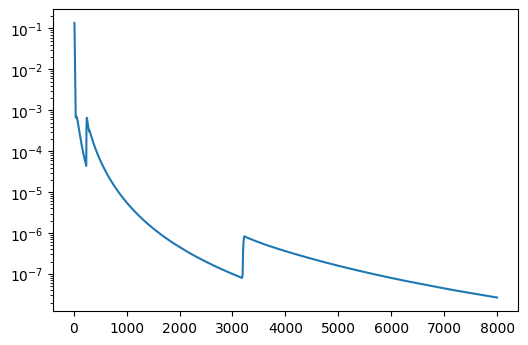

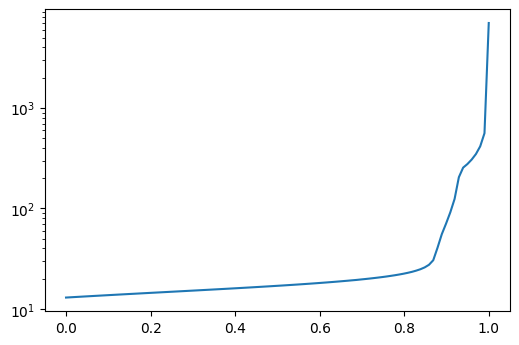

0.06419101928248949
14.57680924639397
highest dE: 7880.138999662334


In [35]:
#Do MC with the ionization yields from 
N_evts = 10000000

#compute the CDF for deltaE from migdal
#dE_max = kin.DeltaE_Max(A, En, c)
dE_min = 13 #13 eV to even ionize a valence electron
dE_max = 8000 #arbitrary cutoff
dE_range = np.geomspace(dE_min, dE_max, 2000)

c = np.cos(np.pi*Angle/180)

probs = []

norm = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 13, dE_max, limit=100, epsrel=1e-3)[0]

for dE in dE_range:
    p = (1/norm)*(integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE,limit=100, epsrel=1e-3)[0])
    probs.append(p)


plt.plot(dE_range, (1/norm)*mig_dE_spectrum(dE_range, c))
plt.yscale('log')
plt.show()
    
migdal_CDF = interp.interp1d(probs, dE_range, bounds_error=False, fill_value=0, kind='linear')
p_space = np.linspace(0, 1, 100)
plt.plot(p_space, migdal_CDF(p_space))
plt.yscale('log')
plt.show()



n_electron_arr = []

migdal_p = 1 - (elastic_xsec/(mig_total_xsec + elastic_xsec))

print(migdal_p)

mig_count = 0
elastic_count = 0


#TODO replace basic quenching with models sent by Alan
highest_dE = 0
for n in range(N_evts):
    r = np.random.rand(1)[0]
    
    if(r < migdal_p):
        mig_count += 1
        s = np.random.rand(1)[0]
        dE = migdal_CDF(s)
        highest_dE = np.maximum(dE,highest_dE)
        recoil_energy = kin.E_Recoil(dE, c, A, En)
        E_ion = recoil_energy*Ar_quench(recoil_energy) + dE
        n_elec = np.floor(E_ion/19.5)
        n_electron_arr.append(n_elec)
        continue
        
    elastic_count += 1
    continue #for now skip eleastic events
    elastic_recoil_E = kin.E_Recoil(0, c, A, En)
    n_elec = np.floor(elastic_recoil_E*Ar_quench(elastic_recoil_E)/19.5) 

    n_electron_arr.append(n_elec)
    
print(elastic_count/mig_count)

#Histogram of results
#we take the normalized histo, multiply by the total cross section, then convert to events/kg/day
scale_factor = (elastic_xsec + mig_total_xsec)*rate_prefactor
scale_factor = 1

highest_bin = 30
bin_edges = np.arange(1, highest_bin + 1, dtype=int)

n_elec_hist, bin_edges = np.histogram(n_electron_arr, bins=bin_edges, density = True)

n_elec_hist = np.multiply(n_elec_hist, scale_factor)

bins = bin_edges[:-1]



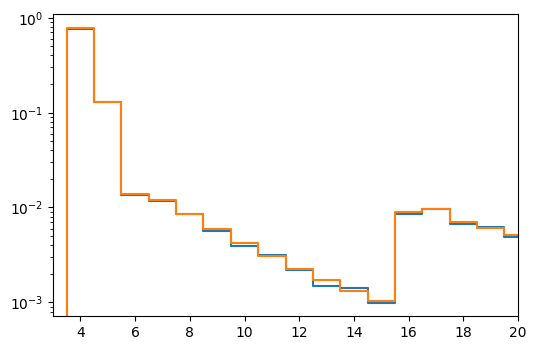

5.958937049139898
[0.         0.         0.         0.76174563 0.12783247 0.01347447
 0.01174366 0.00854528 0.00560701 0.00391876 0.00316054 0.00218164
 0.00150382 0.00140609 0.00099624 0.00853898 0.00956044 0.00676876
 0.00621547 0.00488662 0.00400703 0.00344428 0.00285316 0.00237238
 0.00199879 0.00221317 0.00143446 0.00153692 0.00205396]


In [36]:
plt.step(bins, n_elec_hist,where='mid')

scale_factor = np.sum(n_elec_hist)/(np.sum(binned_migdal_spectrum[1]))
plt.step(binned_migdal_spectrum[0], np.multiply(scale_factor,binned_migdal_spectrum[1]),where='mid')

plt.yscale('log')
plt.xlim(3, 20)
plt.show()